**Udemy 10-3. GAN Code.**

Generating MNIST images using GAN

Device: GPU

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Look weired, but makes pixel values between -1 and +1
# Assume they are transformed from (0, 1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
len(train_dataset)

60000

In [6]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [7]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784,512),
    nn.LeakyReLU(0.2),
    nn.Linear(512,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
)

D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

In [8]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh() # between -1 and +1
)

G.to(device)

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=784, bias=True)
  (10): Tanh()
)

In [9]:
# Loss and Optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# A function to scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2
  return out

In [11]:
# Create a folder to store the generated image
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
# Training Loop

#Labels to use in the loop (these will be used as targets in the training)
# As they are constant, instantiating them inside the loop is wasteful
zeros_ = torch.zeros(batch_size, 1).to(device)
ones_ = torch.ones(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

total_epochs = 200

for epoch in range(total_epochs):
  tic = datetime.now()
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to the device (GPU)
    n = inputs.size(0) # batch_size will not divide evenly in the total number of samples
    inputs = inputs.reshape(n, 784).to(device) # flatten

    #set ones and zeros to the correct size of samples (batch_size)
    ones = ones_[:n]
    zeros = zeros_[:n]

    #############################
    #### Train Discriminator ####
    #############################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #########################
    #### Train Generator ####
    #########################

    # Do it twice - training the generator more than once per epoch may have better results
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels
      g_loss = criterion(fake_outputs, ones)

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save the losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
  
  toc = datetime.now()
  # print and save things
  print(f"Epoch: {epoch+1}/{total_epochs}, d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, Duration: {toc-tic}")

  # Pytorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1,1,28,28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 1/20, d_loss: 0.6797, g_loss: 0.7284, Duration: 0:00:20.361928
Epoch: 2/20, d_loss: 0.6850, g_loss: 0.7682, Duration: 0:00:20.873790
Epoch: 3/20, d_loss: 0.6787, g_loss: 1.0027, Duration: 0:00:20.160586
Epoch: 4/20, d_loss: 0.6804, g_loss: 0.7468, Duration: 0:00:20.264487
Epoch: 5/20, d_loss: 0.6812, g_loss: 0.6938, Duration: 0:00:20.358962
Epoch: 6/20, d_loss: 0.6820, g_loss: 0.7302, Duration: 0:00:20.450019
Epoch: 7/20, d_loss: 0.6853, g_loss: 0.7329, Duration: 0:00:20.544687
Epoch: 8/20, d_loss: 0.6797, g_loss: 0.7050, Duration: 0:00:20.453831
Epoch: 9/20, d_loss: 0.6840, g_loss: 0.7639, Duration: 0:00:20.134723
Epoch: 10/20, d_loss: 0.6669, g_loss: 0.7726, Duration: 0:00:20.371430
Epoch: 11/20, d_loss: 0.6852, g_loss: 0.7021, Duration: 0:00:20.041996
Epoch: 12/20, d_loss: 0.6797, g_loss: 0.7159, Duration: 0:00:20.268871
Epoch: 13/20, d_loss: 0.6912, g_loss: 0.7525, Duration: 0:00:20.008203
Epoch: 14/20, d_loss: 0.6859, g_loss: 0.6970, Duration: 0:00:19.962682
Epoch: 15/20, d

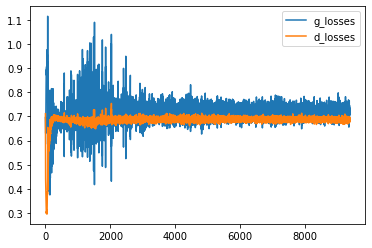

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

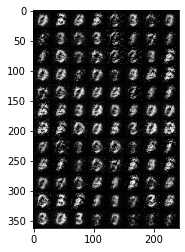

In [14]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

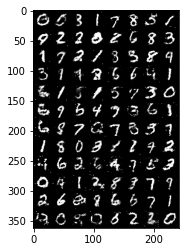

In [15]:
a = imread(f'gan_images/{total_epochs}.png')
plt.imshow(a)